In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import utils
import pickle
from scipy.optimize import minimize

In [2]:
filename = 'data/forAbhi/Contrast_Data.mat'
data = scipy.io.loadmat(filename)
T4_arclight = data['data']*100.0
T4_gcamp = data['data2']*100.0

In [3]:
T4_arclight.shape, T4_gcamp.shape

((113, 48), (113, 48))

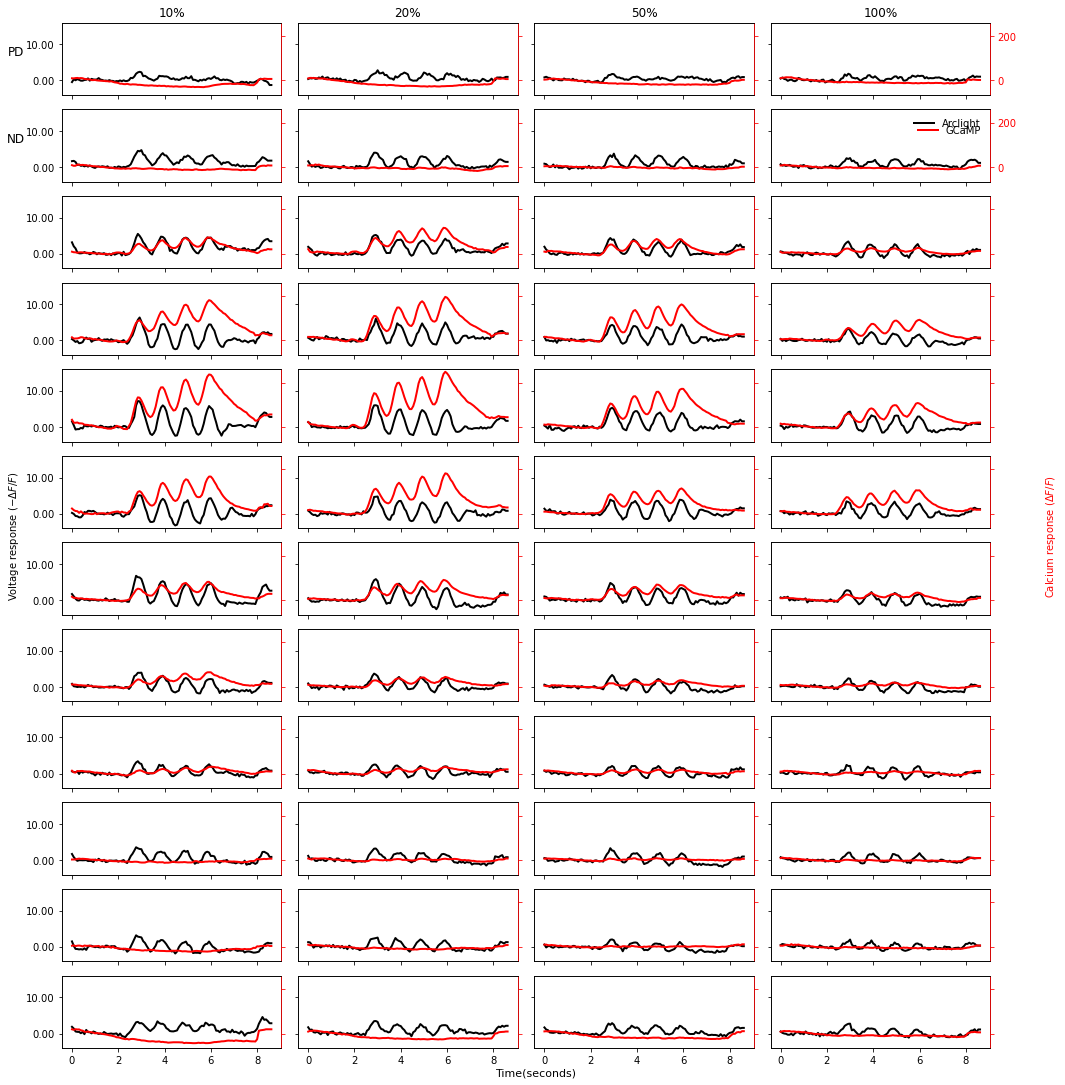

In [5]:
contrast = [10, 20, 50, 100]
#utils.plot_data_twinaxis([T4_arclight[10:,0:8], T4_gcamp[10:,0:8]], ylim=(-0.20,2.50), savefig=True, title='Gratings_SpeedPDND');
#utils.plot_data_twinaxis([T4_arclight, T4_gcamp], fig_size=(15,15),speed=velocity,ylim1=(-0.04,0.10),ylim2=(-0.30,2.60),savefig=False, title='Ori_Vel');
utils.plot_data_twinaxis([T4_arclight, T4_gcamp], fig_size=(15,15),speed=contrast,contrast = True,ylim1=(-4,10),ylim2=(-30,260),savefig=False, title='Ori_Vel');

In [6]:
global p_bounds 
#bounds on parameters (thres, tauhp, taulp1, gain1, taulp2, gain2, tshift)
#p_bounds = ((-300,350),(0,100),(0,500),(0,200),(0,500),(0,200),(-10,10)) 
#bounds on parameters (thres,taulp1, gain1, taulp2, gain2, tshift)
p_bounds = ((-300,350),(0,500),(0,200),(0,500),(0,200),(-10,10))
#p_bounds = ((-1,1),(0,5),(0,200),(0,5),(0,200),(-10,10))
#p_bounds = ((-3,4),(0,1),(0,2),(0,500),(0,5),(0,500),(-10,10))

def lowpass(x, tau, dt):
    y = np.zeros_like(x)
    n = x.shape[0]   #length of time dimension
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,n):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def highpass(x, tau, dt):
    y = x - lowpass(x, tau, dt)
    return y

def bandpass(x, tauhp, taulp, dt):
    y = highpass(x, tauhp, dt)
    y = lowpass(y, taulp, dt)
    return y

def threshold_cut(x, thres):
    x_copy = x.copy()
    x_copy[x_copy<thres] = 0
    return x_copy 

# def Ca_model(x, p, dt=0.0769):
#     """x is Arclight data. p is list of parameters. dt is timestep"""
#     (thres, tauhp, taulp1, gain1, taulp2, gain2, tshift) = p
#     x_thres = threshold_cut(x,thres/100.0)
#     x_thres_bp1 = bandpass(x_thres, tauhp/100, taulp1/100, dt)
#     x_1 = x_thres_bp1 * gain1
#     x_thres_bp2 = bandpass(x_thres, tauhp/100, taulp2/100, dt)
#     x_2 = x_thres_bp2 * gain2
#     y = x_1 + x_2
#     y = np.roll(y, int(tshift), axis=0)
#     return y

def Ca_model(x, p, fig_size=(15,15),dt=0.0769, plot=False):
    """x is Arclight data. p is list of parameters. dt is timestep"""
    (thres, taulp1, gain1, taulp2, gain2, tshift) = p
    x_thres = threshold_cut(x,thres/100.0)
    #x_thres = threshold_cut(x,thres)#/100.0)
    x_thres_lp1 = lowpass(x_thres, taulp1/100.0, dt)
    #x_thres_lp1 = lowpass(x_thres, taulp1, dt)
    x_1 = x_thres_lp1 * gain1
    x_thres_lp2 = lowpass(x_thres, taulp2/100.0, dt)
    #x_thres_lp2 = lowpass(x_thres, taulp2, dt)
    x_2 = x_thres_lp2 * gain2 * x_1
    y = x_1 + x_2
    y = np.roll(y, int(tshift), axis=0)
    if plot==True:
        utils.plot_data([x, x_thres, x_1, x_2, y], fig_size=(15,15),c=['k','grey','g','brown','r']);
    return y

def create_random_params():
    p = [np.random.uniform(bounds[0], bounds[1]) for bounds in p_bounds]
    #print(p)
    return p  

def calc_error(p):
    T4Ca_model = Ca_model(T4_arclight, p)
    #error1 = np.sqrt(np.mean((T4_Gcamp-T4Ca_model)**2)) #timeerror
    error1 = np.mean(np.sqrt(np.mean((T4_gcamp[10:90][:]-T4Ca_model[10:90][:])**2,axis=0)))
    error2 = np.sqrt(np.mean((T4_gcamp.max(axis=0)-T4Ca_model.max(axis=0))**2)) #peakerror
    timeerror = 1.0 #weight for time error
    error = timeerror*error1 + (1.0-timeerror)*error2 #peak error aand time error combined
    return error

def fit_params():
    p = create_random_params() #creates random parameter values
    #options = {'maxiter':5000} #maximum number of iterations
    res = minimize(calc_error, p, tol=1e-10, bounds=p_bounds)#options=options
    if res.success:
        print('Optimisation successful')
    else:
        print('Optimisation not succesfull')
    p = res.x
    error = calc_error(p)
    print('Remaining Error: ', format(calc_error(p),".2f"))
    print(res)
    return p, error

In [7]:
def many_runs(n):
    (p_list, err_list) = ([],[]) 
    for i in range(n):
        print('run : '+str(i))
        (par, err) = fit_params()
        print(par)
        p_list.append(par)
        err_list.append(err)
    return p_list, err_list
    

In [8]:
para_list, err_list = many_runs(100)

run : 0
Optimisation successful
Remaining Error:  30.15
      fun: 30.150144523823556
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -3.55271086e-07, -3.55271338e-07,  0.00000000e+00,
        2.40034481e-01, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 413
      nit: 37
     njev: 59
   status: 0
  success: True
        x: array([157.32432578, 158.75315576,  29.36405104, 340.05430306,
         0.        ,  -8.49021383])
[157.32432578 158.75315576  29.36405104 340.05430306   0.
  -8.49021383]
run : 1
Optimisation successful
Remaining Error:  29.24
      fun: 29.236057959543064
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00, -3.55271591e-07, -1.48148160e-04, -3.19744432e-06,
       -1.03028615e-05,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 441
      nit: 41
     njev: 63
   status: 0
  success: True
        x

Optimisation successful
Remaining Error:  30.72
      fun: 30.719268493627027
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  1.06581477e-06,  3.90798505e-06,  1.06581477e-06,
       -2.84216869e-06,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1750
      nit: 189
     njev: 250
   status: 0
  success: True
        x: array([5.50682273e+01, 9.55907698e+01, 7.04510669e-02, 9.55483598e+01,
       2.00000000e+02, 7.23656728e+00])
[5.50682273e+01 9.55907698e+01 7.04510669e-02 9.55483598e+01
 2.00000000e+02 7.23656728e+00]
run : 15
Optimisation successful
Remaining Error:  30.55
      fun: 30.54810382942662
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  1.42108636e-06, -1.35003109e-05,  3.55271591e-07,
       -5.50670624e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 875
      nit: 91
     njev: 125
   status:

Optimisation successful
Remaining Error:  24.63
      fun: 24.63278671108996
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.        ,  0.        , -0.        ,  0.90678611,
        0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 588
      nit: 61
     njev: 84
   status: 0
  success: True
        x: array([327.00386571, 471.22216003, 159.38320483, 500.        ,
         0.        ,   1.46558209])
[327.00386571 471.22216003 159.38320483 500.           0.
   1.46558209]
run : 29
Optimisation successful
Remaining Error:  30.64
      fun: 30.641408035658046
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  1.74083080e-05,  1.70530257e-05, -1.42108636e-06,
        2.59347893e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 294
      nit: 30
     njev: 42
   status: 0
  success: True
        x: array([-2.74746728e+02,  1.05

Optimisation successful
Remaining Error:  31.42
      fun: 31.418686691023726
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  7.10543182e-07, -3.19744205e-06,  5.21239940e-02,
       -8.02913292e-05,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 504
      nit: 57
     njev: 72
   status: 0
  success: True
        x: array([-267.19184305,  127.09801798,   12.59014675,    0.        ,
          0.39955793,    1.98284833])
[-267.19184305  127.09801798   12.59014675    0.            0.39955793
    1.98284833]
run : 43
Optimisation successful
Remaining Error:  27.22
      fun: 27.217637511860715
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  1.06581402e-06,  0.00000000e+00,
        1.31450405e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 350
      nit: 35
     njev: 50
   status: 0
  success: T

Optimisation successful
Remaining Error:  30.83
      fun: 30.827744004712727
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  3.55271591e-07, -1.38555834e-05,  3.55271591e-07,
       -3.19744233e-06,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 721
      nit: 76
     njev: 103
   status: 0
  success: True
        x: array([-66.41318675, 116.78191635,   2.09228327, 119.13033651,
         6.64521069,   2.95204178])
[-66.41318675 116.78191635   2.09228327 119.13033651   6.64521069
   2.95204178]
run : 57
Optimisation successful
Remaining Error:  32.34
      fun: 32.33790408386869
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00, -7.10542172e-07,  2.27373677e-05, -7.10542172e-07,
        5.61328765e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 924
      nit: 102
     njev: 132
   status: 0
  success: True
      

Optimisation successful
Remaining Error:  31.58
      fun: 31.577090387401626
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00, -3.55271591e-07, -1.10134125e-05,  0.00000000e+00,
       -6.75015603e-06,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 616
      nit: 64
     njev: 88
   status: 0
  success: True
        x: array([-86.98851518, 117.18869305,   2.81451829, 117.87110285,
         4.22430311,   4.44967537])
[-86.98851518 117.18869305   2.81451829 117.87110285   4.22430311
   4.44967537]
run : 71
Optimisation successful
Remaining Error:  26.94
      fun: 26.94184080373097
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.17175239,
       -0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 399
      nit: 40
     njev: 57
   status: 0
  success: True
        x: array([257.16891331, 

Optimisation successful
Remaining Error:  29.26
      fun: 29.25643279201064
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00, -1.06581477e-06,  1.70530258e-05,  0.00000000e+00,
        2.91322523e-05, -0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 609
      nit: 65
     njev: 87
   status: 0
  success: True
        x: array([-145.56884805,  101.82613514,    5.89144841,  100.58290572,
          2.60078698,   -2.90389888])
[-145.56884805  101.82613514    5.89144841  100.58290572    2.60078698
   -2.90389888]
run : 85
Optimisation successful
Remaining Error:  32.65
      fun: 32.64879742867523
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00000000e+00,  0.00000000e+00, -5.68434192e-06,  7.10543182e-07,
       -2.27373677e-05,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 889
      nit: 83
     njev: 127
   status: 0
  success: Tr

Optimisation successful
Remaining Error:  30.69
      fun: 30.691418880992998
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  2.48690114e-06, -1.28146382e-03,  0.00000000e+00,
        1.31450302e-05,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 245
      nit: 23
     njev: 35
   status: 0
  success: True
        x: array([1.44402993e+02, 1.15024014e+02, 1.06956131e-01, 1.15084606e+02,
       1.69038892e+02, 4.93857357e+00])
[1.44402993e+02 1.15024014e+02 1.06956131e-01 1.15084606e+02
 1.69038892e+02 4.93857357e+00]
run : 99
Optimisation successful
Remaining Error:  30.48
      fun: 30.484224204780855
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  3.55271591e-07, -3.75166565e-04,  0.00000000e+00,
       -7.10542172e-07,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 294
      nit: 36
     njev: 42
   status: 0


In [9]:
model_para = para_list[np.argmin(err_list)]
print(np.min(err_list))
print(f'(thres, taulp1, gain1, taulp2, gain2, tshift) = ({model_para[0]/100:.2f}, {model_para[1]/100:.2f},{model_para[2]:.2f}, {model_para[3]/100:.2f}, {model_para[4]:.2f}, {model_para[5]:.2f})')
#print(model_para/100) # (thres, taulp1, gain1, taulp2, gain2, tshift)

22.24137815764057
(thres, taulp1, gain1, taulp2, gain2, tshift) = (3.40, 3.68,154.94, 3.11, 0.00, -3.64)


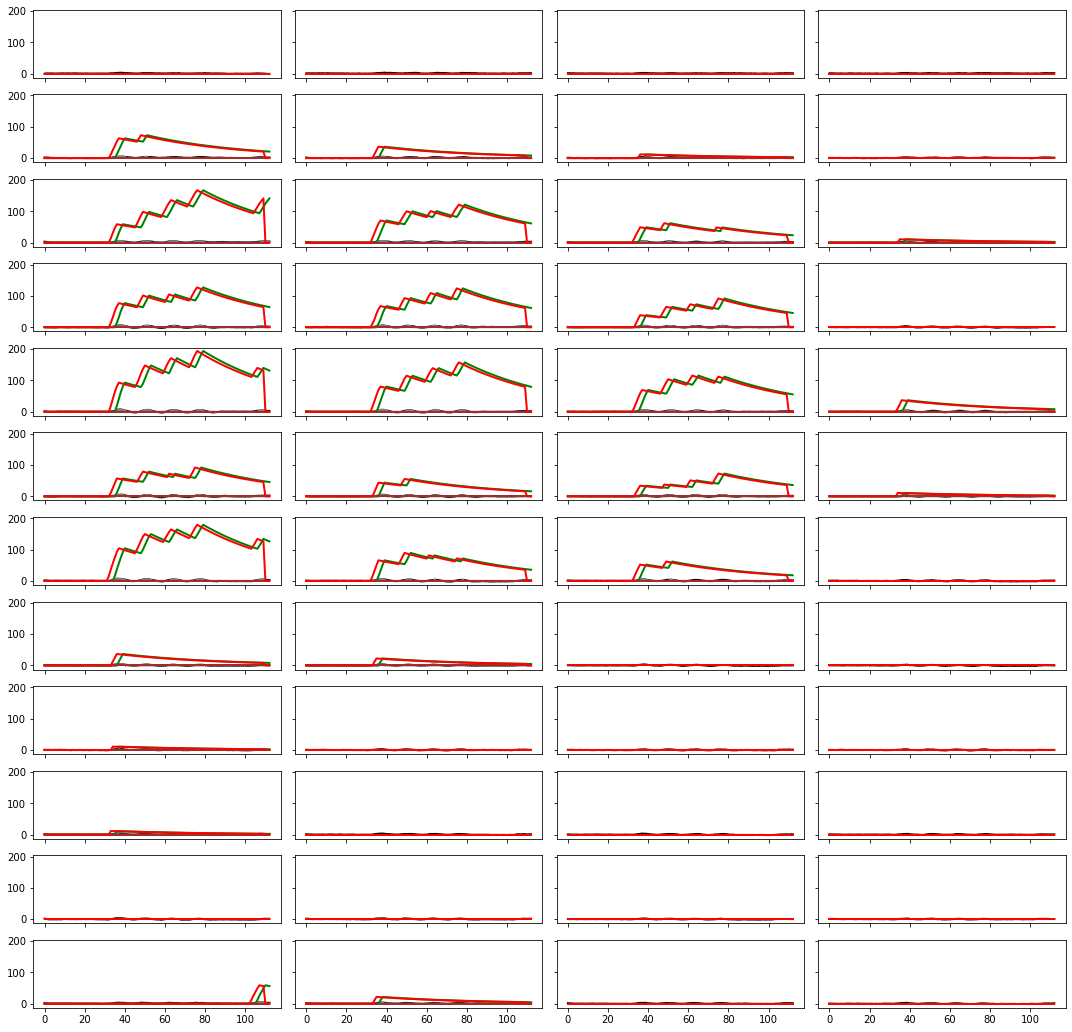

In [10]:
#model_p = fit_params()
T4Ca_model = Ca_model(T4_arclight, model_para, fig_size=(15,15),plot=True)
#plot_data([T4_Gcamp, T4Ca_model])

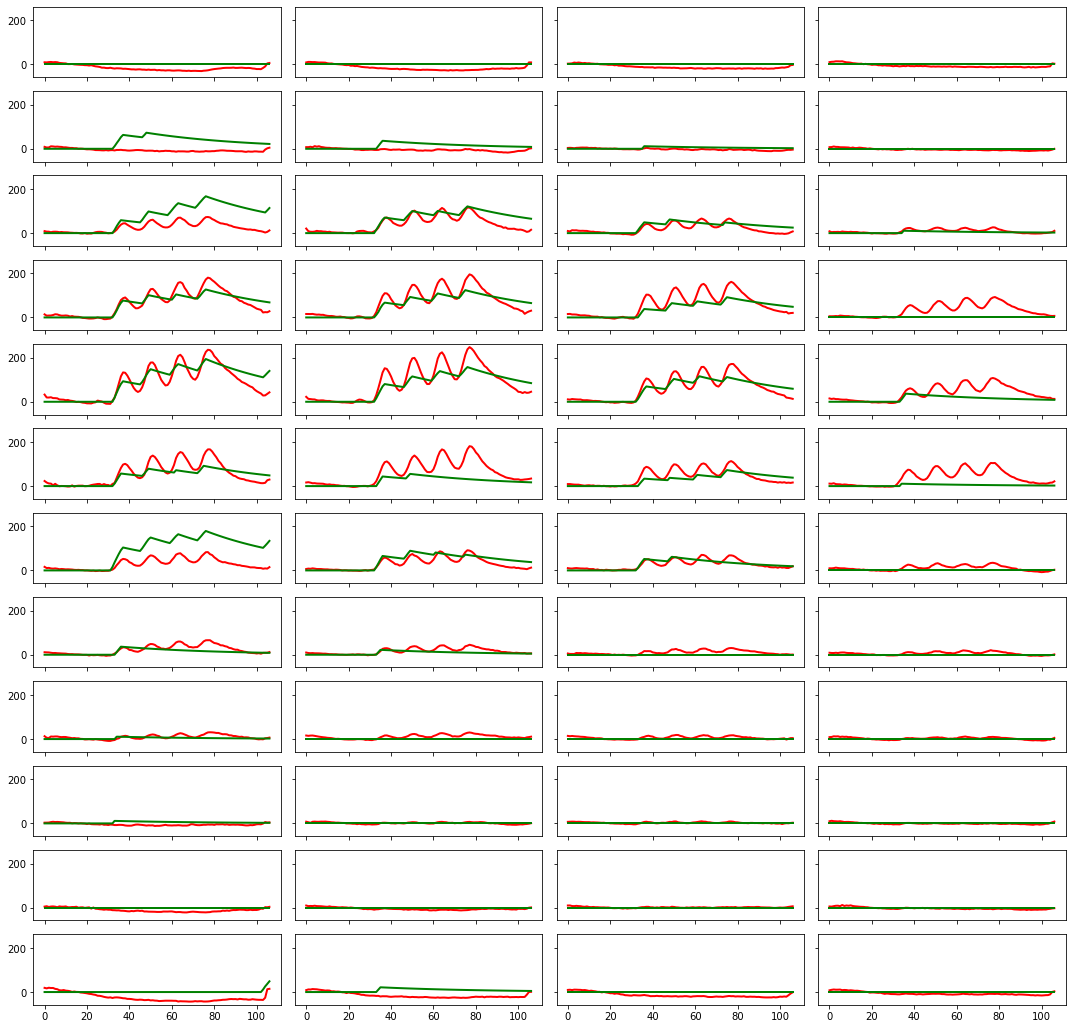

In [11]:
#velocity = [15, 30, 60, 120]
utils.plot_data([T4_gcamp[0:107,:], T4Ca_model[0:107,:]],fig_size=(15,15),speed=contrast,c=['r','g'])
#plt.savefig('figures/scipyminimize/NewModel/CombinedGratingEdge_Gratings_Arclight_Gcamp_scipy_NewModel.pdf',dpi=1000)

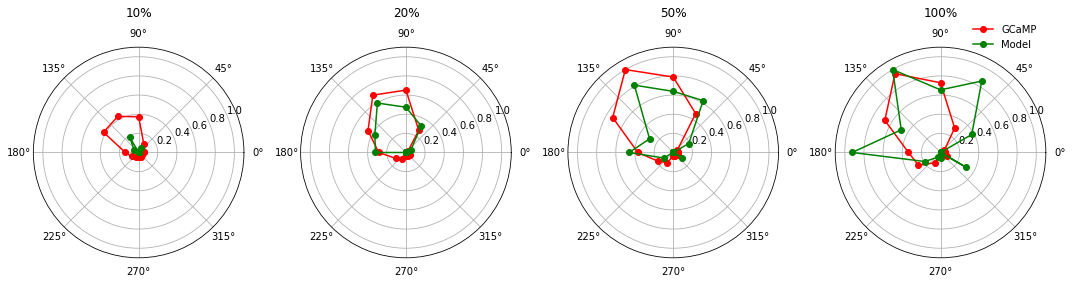

In [13]:
data_list = [T4_gcamp, T4Ca_model]
#velocity = [15, 30, 60, 120]
peak_tuning = utils.calc_peaktuning(data_list, speed=contrast)
utils.plot_oripeaktuning(data_list,speed=contrast, label=['GCaMP','Model'],contrast=True,fig_size=(15,4), ylim1=(0.0,1.1),ylim2=(0.0,1.1),color=['r','g'],title='Speed_Ori_Tuning');